**!!! ДАННЫЙ НОУТБУК ПРЕДНАЗНАЧЕН ТОЛЬКО ДЛЯ ЗАПУСКА В GOOGLE COLAB !!!**

# Детекция лиц в магазине (обучение детектора)

# 1 Блок установки компонентов MMDetection

Выполняется до 40 минут.

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 23075, done.
remote: Total 23075 (delta 0), reused 0 (delta 0), pack-reused 23075
Receiving objects: 100% (23075/23075), 25.84 MiB | 33.88 MiB/s, done.
Resolving deltas: 100% (16157/16157), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.21.0
11.1
GCC 7.5


Загрузка весов предобученной модели

In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/vfnet/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth \
      -O checkpoints/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth

--2022-02-13 14:22:48--  https://download.openmmlab.com/mmdetection/v2.0/vfnet/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395572174 (377M) [application/octet-stream]
Saving to: ‘checkpoints/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth’

checkpoints/vfnet_x 100%[===================>] 377.25M  8.76MB/s    in 46s     

2022-02-13 14:23:37 (8.16 MB/s) - ‘checkpoints/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth’ saved [395572174/395572174]



# 2 Блок импорта необходимых библиотек и инициализация переменных

In [ ]:
import os
import shutil
import random
import shutil
import json

from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import mmcv
from mmcv import Config
from mmdet.apis import set_random_seed

SEED = 2021
random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к рабочей папке модели, используется для записи логов и контрольнях точек.
# А так же содержит исходные данные
SHOP_FACES_MODEL_DIR = '/content/drive/MyDrive/data_science/shop_faces_model'

In [ ]:
# Конфигурация для класса подготовки файлов для обучения детектора
config = {
    'dataset_prepare': {
        # В эту папку будут сохраняться файлы с разметкой KFold-разделения
        'output_dir': f"{SHOP_FACES_MODEL_DIR}/mmdet_config",
        # Путь к файлу ручной разметке боксов лиц
        'csv_filepath': f"{SHOP_FACES_MODEL_DIR}/shop_face_labels.csv",
        # Путь к папке для изображений обучения
        'photo_dir': f"{SHOP_FACES_MODEL_DIR}/train_images/",
        # Требуется ли удалять сломанные боксы
        'remove_broken_box': False,
    },
    'seed': SEED
}

# 3 Набор классов и функций для обучения модели

In [ ]:
class ClassDecoder:
    """ Класс для кодирования названия классов в числа

    Параметры
    ---------
    class_names : list
      Список названий классов. По умолчанию None.
    """

    def __init__(self, class_names=None):
        if class_names:
            self.name_to_idx = {name: id for id, name in enumerate(class_names)}
        else:
            self.name_to_idx = {}

        self.idx_to_name = {id: name for name, id in self.name_to_idx.items()}

    def __len__(self):
        return len(self.name_to_idx)

    def __str__(self):
        return f"ClassDecoder(size={len(self)})"

    def add_class(self, name):
        """ Добавление нового класса

        Параметры
        ---------
        name : str
          Название класса

        Результат
        ---------
        index : int
          Числовая метка класса
        """
        name = str(name).strip()
        if name in self.name_to_idx:
            index = self.name_to_idx[name]
        else:
            index = len(self)
            self.name_to_idx[name] = index
            self.idx_to_name[index] = name
        return index

    def lookup_class(self, name):
        """ Найти номер класса по его имени

        Результат
        ---------
        index : int
          Числовая метка класса
        """
        name = str(name).strip()
        if name not in self.name_to_idx:
            raise Exception(f"Класс {name} не существует")
        index = self.name_to_idx[name]

        return index

    def lookup_index(self, index):
        """ Название класса по индексу

        Результат
        ---------
        class : str
          Название класса
        """
        if index not in self.idx_to_name:
            raise Exception(f"Индекс {index} не существует")

        name = self.idx_to_name[index]

        return name

Класс MMDetectionDatasetPrepare нужен для преобразования файла ручной разметки в данные для обучения детектора из фреймворка MMDetection.

Есть одна особенность - детектор на вход принимает не готовый объект питона, ссылку на файл с разметкой. Поэтому для сохранения данных в файл потребуется сериализация данных (например, конвертация numpy.array в обычный список). Класс хранит в себе как сериализованные данные, так и несериализованные. Сериализованные используются для записи в файл и использовании этих файлов при обучении. А несериализованные можно использовать для тестирования результата работы класса.

In [ ]:
class MMDetectionDatasetPrepare:
    """ Формирование датасета в формате MMDetection V2 

    Для запуска подготовки данных требуется запустить метод prepare.

    После выполнения метода prepare появятся дополнительные свойства объекта:
      Датафрейм с размеченными данными: self.train_df_
      Сериализованное разбиение на фолды: self.fold_train_data_serializable_
      Пути к файлам для обучения с Kfold-разбиением в формате MMDetection Middle: self.fold_configs_

    Параметры
    ---------
    csv_filepath : str
      Путь к файлу с ручной разметкой
    photo_dir : str
      Путь к папке с фото для обучения
    output_dir : str
      Путь к папке для сохранения файлов датасета с Kfold-разбиением
      в формате MMDetection Middle
    remove_broken_box : bool
      Следует ли удалять сломаные боксы. 
      Бокс считается сломаным, если площадь бокса равна нулю или
      его координаты выходят за пределы изображения. По умолчанию False.
    """

    def __init__(self, csv_filepath, photo_dir, output_dir=None, 
                 remove_broken_box=True):
            
        self.output_dir = output_dir
        if self.output_dir is None:
            self.output_dir = '.' + os.path.sep + 'train_files'
        else:
            self.output_dir = str(self.output_dir).strip()
        if self.output_dir[-1] != os.path.sep:
            self.output_dir += os.path.sep
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        if len(os.listdir(self.output_dir)) != 0:
            shutil.rmtree(self.output_dir)
            os.makedirs(self.output_dir)
            
        self.csv_filepath = str(csv_filepath).strip()
        self.photo_dir = str(photo_dir).strip()
        self.remove_broken_box = remove_broken_box

        # Создаем экземпляра класса декодера для кодирования классов
        self.class_decoder_ = ClassDecoder(class_names=['OUT', 'IN'])

        if self.photo_dir[-1] != os.path.sep:
            self.photo_dir += os.path.sep

        assert os.path.exists(self.photo_dir), f"Папка {self.photo_dir} не существует"
        assert os.path.exists(self.csv_filepath), f"CSV-файл с разметкой {self.csv_filepath} не существует"

    def _check_train_df(self):
        """Проверка наличия переменной с обучающим датафреймом"""
        if getattr(self, 'train_df_', None) is None:
            raise Exception("У экземпляра класса отсутствует параметр train_df_, требуется запуск метода _read_csv")

    def _read_csv(self):
        """ Загружаем данные из файла csv

        Функция сохраняет датафрейм в переменную self.train_df_
        """
        correct_df_columns = ['class_label', 'x1', 'y1', 'w', 'h',
                              'filename', 'image_width', 'image_height']

        self.train_df_ = pd.read_csv(self.csv_filepath, delimiter=',')
        assert all(self.train_df_.columns == correct_df_columns), f"Некорректные колонки в файле self.train_csv_path. Ожидаются {correct_df_columns}"
        
    @staticmethod
    def _convert_coo_mmdet(x1, y1, box_width, box_height):
        """ Конвертация формата координат в MMDetection V2

        Принимаемые кординаты не должны быть нормированы относительно
        высоты и ширины изображения
        
        Параметры
        ---------
        x1 : float
          Координата верхнего левого угла бокса по оси x. 
        y1 : float
          Координата верхнего левого угла бокса по оси y.
        box_width : float
          Ширина бокса.
        box_height : float
          Высота бокса.
          
        Результат
        ---------
        x1, y1, x2, y2 : float
          x1 и y1 - координаты верхнего левого угла бокса.
          x2 и y2 - координаты нижнего правого угла бокса.
          Ось y направлена вниз.
        """

        x2 = x1 + box_width
        y2 = y1 + box_height
        
        return x1, y1, x2, y2
    
    @staticmethod
    def _check_box_coordinates(x1, y1, x2, y2, image_width, image_height):
        """ Проверяет корректность координат бокса в формате MMDetection V2
        Координаты бокса не должны иметь нулевую площадь и выходить за пределы фотографии.
        У некоторых моделей такие координаты могут провоцировать ошибку в виде NaN
        
        Результат
        ---------
        Код завершения : int
          0 - ошибок нет
        """
        assert x1 is not None
        assert y1 is not None
        assert x2 is not None
        assert y2 is not None
        assert image_width is not None
        assert image_height is not None
        
        if x1 > x2 or y1 > y2:
            return 1
        if x1 > image_width or x2 > image_width :
            return 2
        if y1 > image_height or y2 > image_height:
            return 3

        return 0   
    
    def _convert_coordinates(self):
        """ Конвертация координат исходного файла в формат MMDetection V2
        
        Результат
        ---------
        В датафрейме self.train_df_. создаются новые колонки x2, y2
        """
        self._check_train_df()  
        
        def coo_converter(row, converter=self._convert_coo_mmdet):
            x1, y1, box_width, box_height = row['x1'], row['y1'], row['w'], row['h']
            x1, y1, x2, y2 = converter(x1=x1, y1=y1, box_width=box_width, 
                                       box_height=box_height)
            return pd.Series([x1, y1, x2, y2], index=['x1', 'y1', 'x2', 'y2'])
        
        self.train_df_.loc[:, ['x1', 'y1', 'x2', 'y2']] = self.train_df_.apply(coo_converter, axis=1)

    def _filter_train_dataframe(self):
        """Фильтрация датафрейма, удаляем позиции, к которым не существует фото

        Требуется предварительно запустить метод self._read_csv()

        Результат
        ---------
        В переменную self.train_df_ сохраняется фильтрованный датафрейм
        """
        self._check_train_df()

        existed_photos = os.listdir(self.photo_dir)
        assert len(existed_photos) > 0, f"В папке {self.photo_dir} нет файлов"

        train_df = self.train_df_.copy()
        train_df.loc[:, 'is_exists'] = train_df.filename.apply(lambda x: 1 if str(x).strip() in existed_photos else 0)

        filtered_df = train_df[train_df.is_exists == 1].copy()

        self.train_df_ = filtered_df
        
    def _mark_broken_coo(self):
        """ Помечаем некорректные координаты.
        
        Результат
        ---------
        В датафрейм self.train_df_ добавляется поле is_broken_coo.
        Если 1 - то координаты сломаны, если 0 - координаты корректные.
        Проверка координат выполняется с помощью метода _check_box_coordinates
        """
        self._check_train_df()
        self.train_df_.loc[:, 'is_broken_coo'] = self.train_df_.apply(lambda x: 1 if self._check_box_coordinates(x['x1'], x['y1'], x['x2'], x['y2'], x['image_width'], x['image_height']) != 0 else 0, axis=1)

    def _set_box_class_number(self):
        """В датафрейме self.train_df_ создаем новый столбец box_class_number.
        Здесь находится числовой номер класса бокса на основе поля class_label"""

        self._check_train_df()
        # Проставляем числовой класс для бокса
        self.train_df_.loc[:, 'box_class_number'] = self.train_df_.class_label.apply(lambda x: self.class_decoder_.lookup_class(x))

    def _make_mmdet_config(self, dataframe, serializable=False):
        """ Создает словари аннотации для каждого фото в формате MMDetection Middle.

        Параметры
        ---------
        dataframe : pd.DataFrame
        serializable : bool
          Если True, то результат будет сериализован

        Результат
        ---------
        coco_dataset : [dict]
          Список словарей в формате MMDetection Middle.
          Каждый словарь - полное описание одного фото.
          [
              {'filename': Путь к изображению, 
                'width': Ширина изображения,
                'height': Высота изображения,
                'ann': [
                    {
                        # Координаты боксов на фото
                        'bboxes': [(x1, y1, x2, y2), ...],
                        # Метки класса боксов на фото
                        'labels': [label1, label2, ...],
                    }
                ]}
           ]
        """    

        data_infos = []

        for _, photo_df in dataframe.groupby('filename'):

            image_height = int(photo_df['image_height'].values[0])
            image_width = int(photo_df['image_width'].values[0])
            filename = self.photo_dir + photo_df['filename'].values[0]

            data_info = dict(filename=filename, width=image_width, height=image_height)

            gt_bboxes = []
            gt_labels = []

            for _, photo_row in photo_df.iterrows():

                photo_row = photo_row.to_dict()
                
                if self.remove_broken_box and photo_row['is_broken_coo'] == 1:
                    continue
                    
                box_class = int(photo_row['box_class_number'])

                x1 = photo_row['x1']
                y1 = photo_row['y1']
                x2 = photo_row['x2']
                y2 = photo_row['y2']
                
                gt_bbox = [x1, y1, x2, y2]

                gt_bboxes.append(gt_bbox)
                gt_labels.append(box_class)
                
            if len(gt_bboxes) == 0:
                continue

            if serializable:
                data_anno = dict(
                    bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4).tolist(),
                    labels=np.array(gt_labels, dtype=np.long).tolist(),
                )
            else:
                data_anno = dict(
                    bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                    labels=np.array(gt_labels, dtype=np.long),
                )

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

    def _make_train_val_mmdet_config(self, folds=3, serializable=False):
        """ Запуск формирования словарей конфигураций  MMDetection V2 для обучения
        и валидации

        Параметры
        ---------
        folds : int
          Количество фолдов для разбиения данных
        serializable : bool
          Если True, то метод вернет сериализованные данные

        Результат
        ---------
        fold_configs : list
          Список конфигураций для каждого фолда
          [(конфиг обучения фолд 2, конфиг валидации фолд 1),
          (конфиг обучения фолд 2, конфиг валидации фолд 2), ...]
        """

        fold_dataframes = []
        fold_configs = []

        size_dataframe = len(self.train_df_)
        fold_size = size_dataframe // folds

        for fold_number in range(folds):
            if fold_number == folds-1:
               fold_dataframes.append(self.train_df_.iloc[fold_size*fold_number:]) 
            else:
                fold_dataframes.append(self.train_df_.iloc[fold_size*fold_number:fold_size*fold_number+fold_size])
        
        for fold_number in range(folds):

            train_dataframe = pd.concat([df for idx, df in enumerate(fold_dataframes) if idx != fold_number])
            val_dataframe = fold_dataframes[fold_number]

            train_dataset = self._make_mmdet_config(train_dataframe, serializable=serializable)
            val_dataset = self._make_mmdet_config(val_dataframe, serializable=serializable)

            fold_configs.append((train_dataset, val_dataset))

        return fold_configs

    def _save_configs(self):
        """ Сохранение конфигураций  MMDetection V2 в файл

        Результат
        ---------
        В переменные self.fold_train_data_filepaths_  сохраняются пути к файлам 
        на диске в следующем формате: 
          [(путь к файлу обучения фолд 1, путь к файлу валидации фолд 1), 
           (путь к файлу обучения фолд 2, путь к файлу валидации фолд 2), ...]
        """

        if getattr(self, 'fold_train_data_serializable_', None) is None:
            raise Exception("У экземпляра класса отсутствует параметр fold_train_data_serializable_")

        self.fold_train_data_filepaths_ = []
        
        for fold_number, (fold_train_data, fold_val_data) in enumerate(self.fold_train_data_serializable_):
            train_config_path = self.output_dir if self.output_dir is not None else ""
            train_config_path += f'fold{fold_number}_train.json'
            val_config_path = self.output_dir if self.output_dir is not None else ""
            val_config_path += f'fold{fold_number}_val.json'

            with open(train_config_path, 'w', encoding='utf-8') as f:
                f.write(json.dumps(fold_train_data))
            with open(val_config_path, 'w', encoding='utf-8') as f:
                f.write(json.dumps(fold_val_data))

            self.fold_train_data_filepaths_.append((train_config_path, val_config_path))

    def prepare(self, folds=3):
        """ Запуск подготовки датасетов
        """
        self._read_csv()
        self._convert_coordinates()
        self._filter_train_dataframe()
        self._mark_broken_coo()
        self._set_box_class_number()
        self.fold_configs_ = self._make_train_val_mmdet_config(folds=folds)
        self.fold_train_data_serializable_ = self._make_train_val_mmdet_config(folds=folds, serializable=True)
        self._save_configs()

# 4 Подготовка файлов обучения и проверка корректности данных

In [ ]:
dataset = MMDetectionDatasetPrepare(**config['dataset_prepare'])
dataset.prepare(folds=3)

In [ ]:
def print_box(coco_img_description):
    img = cv2.imread(coco_img_description['filename'], cv2.IMREAD_COLOR)
    for box in coco_img_description['ann']['bboxes']:
        x1, y1, x2, y2 = [int(val) for val in box]
        img = cv2.rectangle(img=img, pt1=(x1, y1), pt2=(x2, y2), 
                            color=(0, 0, 255), thickness=10)
    plt.figure(figsize=(15, 15))
    plt.imshow(img[::, ::, ::-1])
    plt.show()

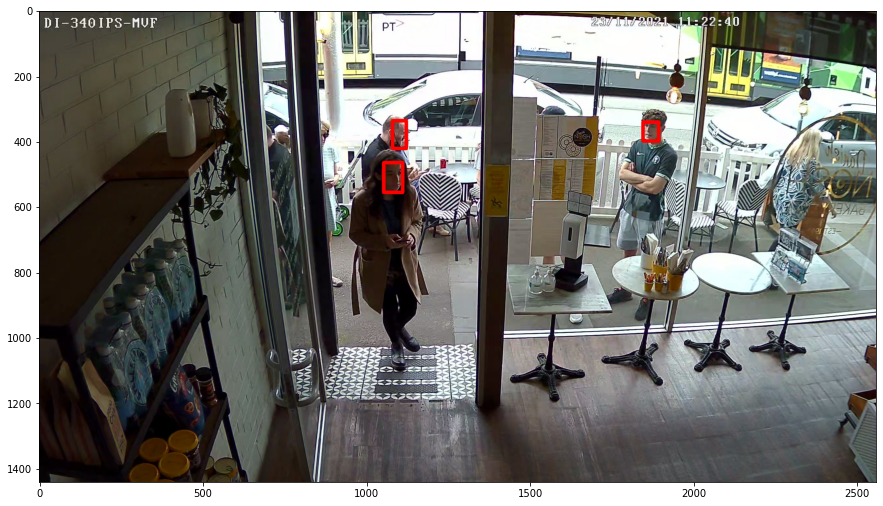

In [ ]:
print_box(dataset.fold_configs_[0][0][23])

In [ ]:
dataset.fold_train_data_filepaths_

[('/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold0_train.json',
  '/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold0_val.json'),
 ('/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold1_train.json',
  '/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold1_val.json'),
 ('/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold2_train.json',
  '/content/drive/MyDrive/data_science/shop_faces_model/mmdet_config/fold2_val.json')]

# 5 Необходимые классы для обучения модели и ее конфигурация

In [ ]:
@DATASETS.register_module(force=True)
class ShopFacesDataset(CustomDataset):
    """ Класс для генерации данных модели детектора
    """

    # Указываем расшифровку классов
    # 0 - OUT
    # 1 - IN
    CLASSES = ('OUT', 'IN')

    def load_annotations(self, ann_file):
        """
        Загрузка аннотации для изображений
        Параметры
        ---------
        ann_file : txt
          Путь к файлу с разметкой в формате  MMDetection V2 
        """

        with open(self.ann_file, 'r', encoding='utf-8') as f:
            dataset = json.loads(f.read())

        for image_data in dataset:

            image_data['ann']['bboxes'] = np.array(image_data['ann']['bboxes'], dtype=np.float32)
            image_data['ann']['labels'] = np.array(image_data['ann']['labels'], dtype=np.long)
    
        return dataset

Для обучения будем использовать только данные из первого фолда

In [ ]:
TRAIN_DATASET = dataset.fold_train_data_filepaths_[0][0]
VAL_DATASET = dataset.fold_train_data_filepaths_[0][1]

Создание файла конфигурации для обучения детектора

In [ ]:
def make_config(train_ann_file, val_ann_file,
                print_cfg=True, test_scale_coef=1):

    cfg = Config.fromfile('./configs/vfnet/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco.py')
    cfg.work_dir = f"{SHOP_FACES_MODEL_DIR}/vfnet_logs/"
    cfg.load_from = "checkpoints/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth"
    cfg.optimizer.lr = 0.01 / 8
    cfg.model.bbox_head.num_classes = 2

    cfg.data.train.pipeline = [
        dict(type='LoadImageFromFile'),
        dict(type='LoadAnnotations', with_bbox=True),
        dict(
            type='RandomCrop',
            crop_type='relative_range',
            crop_size=(0.75, 0.75)),
        dict(
            type='Resize',
            img_scale=[(1333, 480), (1333, 960)],
            multiscale_mode='range',
            keep_ratio=True),
        dict(
            type='CutOut',
            n_holes=(5, 10),
            cutout_shape=[(4, 4), (4, 8), (8, 4), (8, 8), (16, 8), (8, 16),
                            (16, 16), (16, 32), (32, 16), (32, 32), (32, 48),
                            (48, 32), (48, 48)]),
        dict(type='RandomFlip', flip_ratio=0.5),
        dict(
            type='Normalize',
            mean=[123.675, 116.28, 103.53],
            std=[58.395, 57.12, 57.375],
            to_rgb=True),
        dict(type='Pad', size_divisor=32),
        dict(type='DefaultFormatBundle'),
        dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
    ]

    cfg.samples_per_gpu=1

    cfg.data.val.pipeline[1].img_scale = (int(1333*test_scale_coef), int(960*test_scale_coef))
    cfg.data.test.pipeline[1].img_scale = (int(1333*test_scale_coef), int(960*test_scale_coef))

    cfg.data_root = config['dataset_prepare']['photo_dir']

    cfg.runner.max_epochs = 100

    cfg.workflow = [('train', 1)]
    cfg.dataset_type = "ShopFacesDataset"

    cfg.data.train.type = "ShopFacesDataset"
    cfg.data.train.ann_file = train_ann_file
    cfg.data.train.img_prefix = cfg.data_root

    # Настраиваем валидационный датасет
    cfg.data.val.type = "ShopFacesDataset"
    cfg.data.val.ann_file = val_ann_file
    cfg.data.val.img_prefix = cfg.data_root

    # Настраиваем тестовый датасет
    cfg.data.test.type = "ShopFacesDataset"
    cfg.data.test.ann_file = val_ann_file
    cfg.data.test.img_prefix = cfg.data_root

    # Change the evaluation metric since we use customized dataset.
    cfg.evaluation.metric = 'mAP'
    # We can set the evaluation interval to reduce the evaluation times
    cfg.evaluation.interval = 1
    # We can set the checkpoint saving interval to reduce the storage cost
    cfg.checkpoint_config.interval = 1
    cfg.evaluation.save_best='mAP'

    cfg.log_config.interval = 50

    # Set seed thus the results are more reproducible
    cfg.seed = SEED
    set_random_seed(SEED, deterministic=False)

    cfg.gpu_ids = range(1)
                
    # We can initialize the logger for training and have a look
    # at the final config used for training
    if print_cfg:
        print(f'Config:\n{cfg.pretty_text}')
    
    return cfg

vfnet_config = make_config(train_ann_file=dataset.fold_train_data_filepaths_[0][0],
                           val_ann_file=dataset.fold_train_data_filepaths_[0][1],
                           print_cfg=True, 
                           test_scale_coef=1.0)

Config:
dataset_type = 'ShopFacesDataset'
data_root = '/content/drive/MyDrive/data_science/shop_faces_model/train_images/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        img_scale=[(1333, 480), (1333, 960)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_rati

# 5 Обучение детектора

In [ ]:
# Build dataset
datasets = [build_dataset(vfnet_config.data.train)]

# Build the detector
model = build_detector(vfnet_config.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

torch.cuda.empty_cache()

/content/mmdetection/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [ ]:
train_detector(model, datasets, vfnet_config, distributed=False, validate=True)

2022-02-13 13:13:49,134 - mmdet - INFO - load checkpoint from local path: checkpoints/vfnet_x101_64x4d_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-b5f6da5e.pth
2022-02-13 13:13:49,749 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([2]).
2022-02-13 13:13:49,760 - mmdet - INFO - Start running, host: root@f5cee1a2d9ff, work_dir: /content/drive/MyDrive/data_science/shop_faces_model/vfnet_logs
2022-02-13 13:13:49,761 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY

[>                                 ] 1/23, 1.7 task/s, elapsed: 1s, ETA:    13s

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 23/23, 3.1 task/s, elapsed: 7s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-13 13:16:47,844 - mmdet - INFO - 
+-------+-----+------+--------+-------+
| class | gts | dets | recall | ap    |
+-------+-----+------+--------+-------+
| OUT   | 52  | 1652 | 0.462  | 0.025 |
| IN    | 19  | 648  | 0.789  | 0.086 |
+-------+-----+------+--------+-------+
| mAP   |     |      |        | 0.056 |
+-------+-----+------+--------+-------+
2022-02-13 13:16:52,055 - mmdet - INFO - Now best checkpoint is saved as best_mAP_epoch_1.pth.
2022-02-13 13:16:52,057 - mmdet - INFO - Best mAP is 0.0555 at 1 epoch.
2022-02-13 13:16:52,058 - mmdet - INFO - Epoch(val) [1][23]	AP50: 0.0560, mAP: 0.0555


KeyboardInterrupt: ignored

In [ ]:
def plot_result(image_path, result, class_print=1, prob_thr=0.5, area_thr=0):

    assert class_print in (0,1)

    image = mmcv.imread(image_path)

    for class_idx, class_predict in enumerate(result):
        if class_idx != class_print:
            continue
        filtered_idx = np.where(class_predict[:, 4] > prob_thr)[0]

        filtered_boxes = []
        for box_predict in class_predict[filtered_idx]:
            box_width = box_predict[2] - box_predict[0]
            box_height = box_predict[3] - box_predict[1]
            box_area = box_width*box_height
            if box_area < area_thr:
                continue
            filtered_boxes.append(box_predict)
    
    for model_result in filtered_boxes:
        bbox = model_result[:4]
        conf = model_result[4]

        x1, y1, x2, y2 = bbox
        image = cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), 
                                color=(0, 0, 255), thickness=10)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(image[::,::,::-1])
    plt.show()

In [ ]:
checkpoint = f"{SHOP_FACES_MODEL_DIR}/vfnet_logs/epoch_80.pth"
vfnet_config.model.test_cfg.nms.iou_threshold = 0.5
vfnet_model = init_detector(vfnet_config, checkpoint, device='cuda:0')
vfnet_model.CLASSES = ('OUT', 'IN')

load checkpoint from local path: /content/drive/MyDrive/data_science/shop_faces_model/vfnet_logs/epoch_80.pth


2022-02-13 14:23:50,810 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-02-13 14:23:50,816 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-02-13 14:23:50,821 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-02-13 14:23:50,831 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-02-13 14:23:50,837 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-02-13 14:23:50,844 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-02-13 14:23:50,850 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-02-13 14:23:50,855 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-02-13 14:23:50,861 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

In [ ]:
image_path = f"{SHOP_FACES_MODEL_DIR}/train_images/298.jpg"
vfnet_img = mmcv.imread(image_path)
result = inference_detector(vfnet_model, vfnet_img)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


## Тест детекции на лицах в магазине (без использования фильтра по площади)

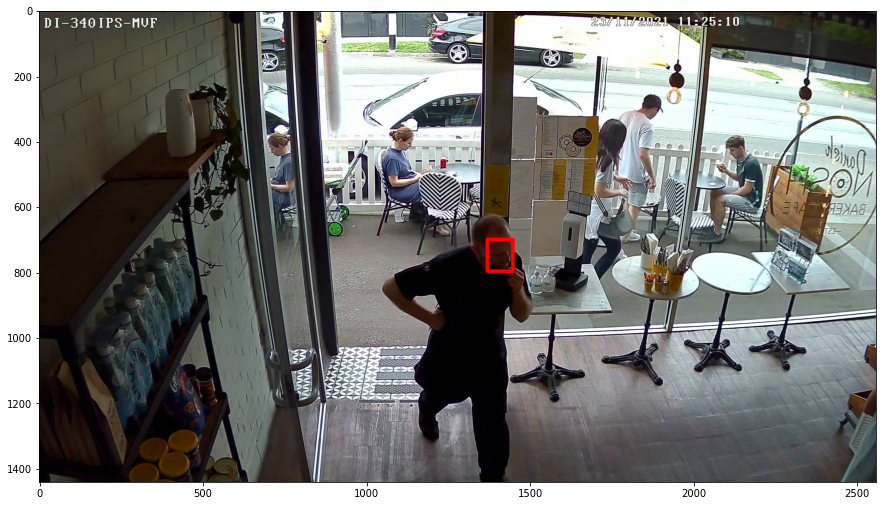

In [ ]:
plot_result(image_path, result, class_print=1, prob_thr=0.8, area_thr=0.0)

Тест детекции на лицах вне магазина (без использования фильтра по площади)

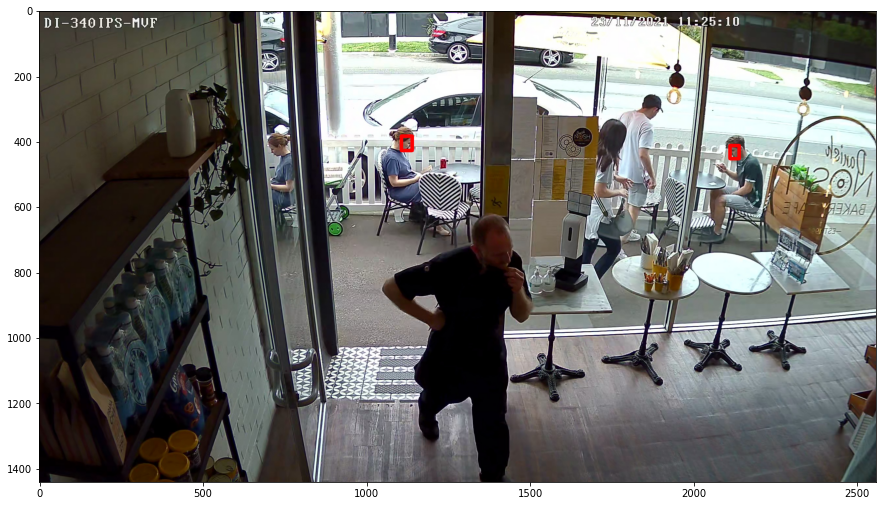

In [ ]:
plot_result(image_path, result, class_print=0, prob_thr=0.1, area_thr=0.0)